In [1]:
from mpi4py import MPI
import numpy as np
import dxchange
import torch as tc
import os
import torch as tc
import torch.nn.functional as F
from tqdm import tqdm
import csv

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm


In [2]:
## For a 64 x 64 x 64 sample: sample8 ##
######################################################################
dev = 'cpu'
# experiemtal parameters #
theta_st = tc.tensor(0).to(dev)
theta_end = tc.tensor(2 * np.pi).to(dev)
n_theta =  tc.tensor(200).to(dev)
theta_ls = - tc.linspace(theta_st, theta_end, n_theta+1)[:-1].to(dev)
sample_size_n = tc.tensor(64).to(dev)
sample_height_n = tc.tensor(64).to(dev)
sample_size_cm = tc.tensor(0.01).to(dev)
this_aN_dic = {"Ca": 20, "Sc": 21}
probe_energy = np.array([20.0])
probe_cts = tc.tensor(1.0E7).to(dev)
det_size_cm = 0.24
det_from_sample_cm = 1.6
det_ds_spacing_cm = 0.1

# path of true grid concentration of the sample #
grid_path = './data/sample8_size_64_pad/nElements_2'
f_grid = 'grid_concentration.npy'

# XRF and XRT data path #
data_path = './data/sample8_size_64_data/nElements_2/nThetas_200_limitedSolidAngle/solidAngle_frac_0.0156/Noise'
f_XRF_data = 'XRF_sample8'
f_XRT_data = 'XRT_sample8'

# path of storing the intersecting information and the reconstructing results #
recon_path_selfAb = 'data/sample8_size_64_recon/limited_solid_angle/Noise/detSpacing_0.4_dpts_5/b_1.56E-5/nElements_2_selfAb_nEpochs_40_nThetas_200_singleGPU_Pbackup5_monitoring'
f_recon_grid = 'grid_concentration'
f_initial_guess = 'initialized_grid_concentration'
f_mse_model = 'mse_model'

# WO self-absorption: path of storing the intersecting information and the reconstructing results #
recon_path_woSelfAb = 'data/sample8_size_64_recon/limited_solid_angle/Noise/detSpacing_0.4_dpts_5/b_1.56E-5/nElements_2_selfAb_nEpochs_40_nThetas_200_h5test_mpi_n_ranks_1_monitoring'
f_recon_grid = 'grid_concentration'
f_initial_guess = 'initialized_grid_concentration'
f_mse_model = 'mse_model'
######################################################################


## XRF Sinogram

In [11]:
layer_idx_ls = [38, 40]

(200, 4, 4096)
2605.0
2678.0
2346.0
2635.0


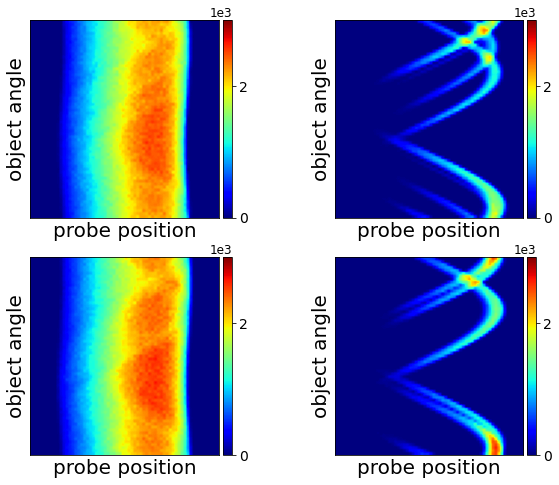

In [13]:
n_elements = len(this_aN_dic)
line_idx_all_elements_ls = [[0, 1], [2, 3]]
n_theta_cpu =  n_theta.to("cpu")
n_theta_ds_factor = 3

XRF_data = np.array([np.load(os.path.join(data_path, f_XRF_data)+'_{}'.format(i) + '.npy').astype(np.float32) for i in range(n_theta)])
print(XRF_data.shape) # (n_theta, n_lines, n_probe_pos)

fig6 = plt.figure(figsize=(10, 8))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=n_elements)
# fig6.text(0.270, 0.89, 'Ca', color='black', fontsize=24)
# fig6.text(0.700, 0.89, 'Sc', color='black', fontsize=24)
for i_element in range(n_elements):
    for idx, layer_idx in enumerate(layer_idx_ls):
        probe_pos_st = 64 * layer_idx
        probe_pos_end = 64 * (layer_idx + 1)
        XRF_data_ds = np.zeros(XRF_data[::n_theta_ds_factor, 0, probe_pos_st:probe_pos_end].shape)
        line_idx_ls = line_idx_all_elements_ls[i_element]
        for line_idx in line_idx_ls:
            XRF_data_ds += XRF_data[::n_theta_ds_factor, line_idx, probe_pos_st:probe_pos_end]
        print(np.max(XRF_data_ds))
        fig6_ax1 = fig6.add_subplot(gs6[idx, i_element])
        pos = fig6_ax1.imshow(XRF_data_ds, cmap='jet', vmin=0, vmax= 3000, extent=[0,probe_pos_end-probe_pos_st, XRF_data_ds.shape[0], 0], origin='upper')
        plt.setp(fig6_ax1.get_xticklabels(), visible=False)
        plt.setp(fig6_ax1.get_yticklabels(), visible=False)
        fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.arange(0, 12000, 2000)
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)   
        cbar.ax.tick_params(labelsize=14) 
        cbar.formatter.set_powerlimits((0, 0))
        fig6_ax1.set_xlabel("probe position", fontsize=20)
        fig6_ax1.set_ylabel("object angle", fontsize=20)
    # cbar.ax.set_title('XRF signal', size='14')
# plt.savefig('XRF_sinogram.pdf', format='pdf', dpi=600)



## XRT Sinogram

(200, 4096)


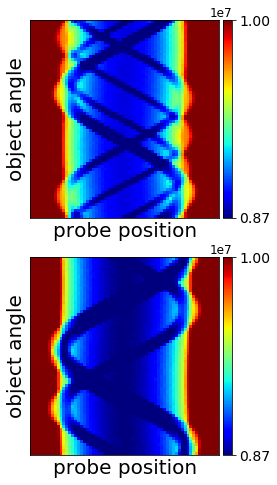

In [5]:
n_elements = len(this_aN_dic)
layer_idx_ls = [30, 40]
n_theta_cpu =  n_theta.to("cpu")
n_theta_ds_factor = 3

XRT_data = np.array([np.load(os.path.join(data_path, f_XRT_data)+'_{}'.format(i) + '.npy').astype(np.float32) for i in range(n_theta)])
print(XRT_data.shape)

fig6 = plt.figure(figsize=(5, 8))
gs6 = gridspec.GridSpec(nrows=len(layer_idx_ls), ncols=1)

for idx, layer_idx in enumerate(layer_idx_ls):
    probe_pos_st = 64 * layer_idx
    probe_pos_end = 64 * (layer_idx + 1)
    XRT_data_ds = XRT_data[::n_theta_ds_factor, probe_pos_st:probe_pos_end]
    fig6_ax1 = fig6.add_subplot(gs6[idx])
    pos = fig6_ax1.imshow(XRT_data_ds, cmap='jet', vmin=8700000, vmax= 10000000, extent=[0,probe_pos_end-probe_pos_st, XRT_data_ds.shape[0], 0], origin='upper')
    plt.setp(fig6_ax1.get_xticklabels(), visible=False)
    plt.setp(fig6_ax1.get_yticklabels(), visible=False)
    fig6_ax1.tick_params(axis='both', which='both', length=0)
#         fig6_ax1.axis('off')
    divider = make_axes_locatable(fig6_ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ticks = np.array([8700000, 10000000])
    cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.tick_params(labelsize=14) 
    fig6_ax1.set_xlabel("probe position", fontsize=20)
    fig6_ax1.set_ylabel("object angle", fontsize=20)
# cbar.ax.set_title('XRF signal', size='14')
plt.savefig('XRT_sinogram.pdf', format='pdf', dpi=600)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


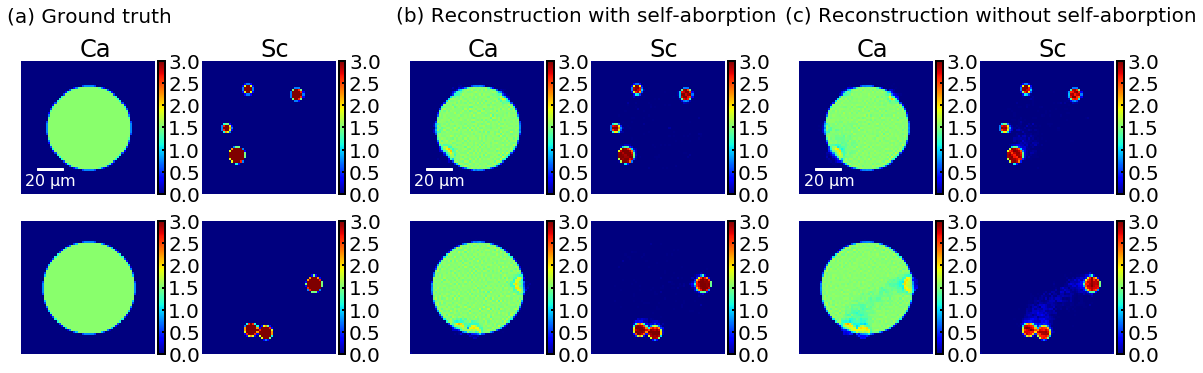

In [6]:
# layer_idx_ls = range(0,5,1)
layer_idx_ls = [30, 40]

gt = np.load(os.path.join(grid_path, f_grid))
recon_selfAb = np.load(os.path.join(recon_path_selfAb, f_recon_grid + '.npy'))
recon_woSelfAb = np.load(os.path.join(recon_path_woSelfAb, f_recon_grid + '.npy'))

image_size = gt.shape[-1]
fig6 = plt.figure(figsize=(2.5 * (3*gt.shape[0]+2) , 3*len(layer_idx_ls)*0.9))
gs6 = gridspec.GridSpec(nrows = len(layer_idx_ls), ncols=3 * gt.shape[0]+2, width_ratios=[2]*gt.shape[0]+[0.05]+[2]* gt.shape[0]+[0.05]+[2]* gt.shape[0])

fig6.text(0.13-0.01, 0.98, '(a) Ground truth', color='black', fontsize=20)
fig6.text(0.4-0.01, 0.98, '(b) Reconstruction with self-aborption', color='black', fontsize=20)
fig6.text(0.67-0.01, 0.98, '(c) Reconstruction without self-aborption', color='black', fontsize=20)

fig6.text(0.135+0.035, 0.89, 'Ca', color='black', fontsize=24)
fig6.text(0.261+0.035, 0.89, 'Sc', color='black', fontsize=24)
fig6.text(0.405+0.035, 0.89, 'Ca', color='black', fontsize=24)
fig6.text(0.531+0.035, 0.89, 'Sc', color='black', fontsize=24)
fig6.text(0.675+0.035, 0.89, 'Ca', color='black', fontsize=24)
fig6.text(0.801+0.035, 0.89, 'Sc', color='black', fontsize=24)

for element_idx in range(gt.shape[0]):
    for idx, layer_idx in enumerate(layer_idx_ls):
        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
        pos = fig6_ax1.imshow(gt[element_idx,layer_idx], cmap='jet', vmin=0, vmax=3.0, extent=[0, image_size, image_size, 0], origin='upper')
        if element_idx == 0 and idx == 0:
            scalebar = AnchoredSizeBar(fig6_ax1.transData,
                                       12.5, r'20 $\mathrm{\mu m} $', 'lower left', 
                                       pad=0.1,
                                       color='white',
                                       frameon=False,
                                       size_vertical=1,
                                       fontproperties=fm.FontProperties(size=16))
            fig6_ax1.add_artist(scalebar)
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.arange(0,3.5,0.5)
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=20, direction='in', width=2)
        cbar.outline.set_linewidth(2)
      
        
#         cbar.ax.set_title('intensity', size='14')
        
        fig6_ax2 = fig6.add_subplot(gs6[idx, element_idx+3])
        fig6_ax2.set_xticks(np.arange(0, image_size, 1))
        fig6_ax2.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax2.axis('off')
        pos = fig6_ax2.imshow(recon_selfAb[element_idx,layer_idx], cmap='jet', vmin=0, vmax=3.0, extent=[0, image_size, image_size, 0], origin='upper')
        if element_idx == 0 and idx == 0:
            scalebar = AnchoredSizeBar(fig6_ax2.transData,
                                       12.5, r'20 $\mathrm{\mu m} $', 'lower left', 
                                       pad=0.1,
                                       color='white',
                                       frameon=False,
                                       size_vertical=1,
                                       fontproperties=fm.FontProperties(size=16))
            fig6_ax2.add_artist(scalebar)
        divider = make_axes_locatable(fig6_ax2)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.arange(0,3.5,0.5)
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=20, direction='in', width=2)
        cbar.outline.set_linewidth(2)
#         cbar.ax.set_title('intensity', size='14')

        fig6_ax3 = fig6.add_subplot(gs6[idx, element_idx+6])
        fig6_ax3.set_xticks(np.arange(0, image_size, 1))
        fig6_ax3.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax3.axis('off')
        pos = fig6_ax3.imshow(recon_woSelfAb[element_idx,layer_idx], cmap='jet', vmin=0, vmax=3.0, extent=[0, image_size, image_size, 0], origin='upper')
        if element_idx == 0 and idx == 0:
            scalebar = AnchoredSizeBar(fig6_ax3.transData,
                                       12.5, r'20 $\mathrm{\mu m} $', 'lower left', 
                                       pad=0.1,
                                       color='white',
                                       frameon=False,
                                       size_vertical=1,
                                       fontproperties=fm.FontProperties(size=16))
            fig6_ax3.add_artist(scalebar)  
            ticks = np.arange(0,3.5,0.5)
        divider = make_axes_locatable(fig6_ax3)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=20, direction='in', width=2)
        cbar.outline.set_linewidth(2)
#         cbar.ax.set_title('intensity', size='14')



plt.savefig('Self_absorption_effect.pdf', format='pdf', dpi=600)


In [6]:
print(np.max(recon_selfAb))

3.3479426


## Plot error convergence

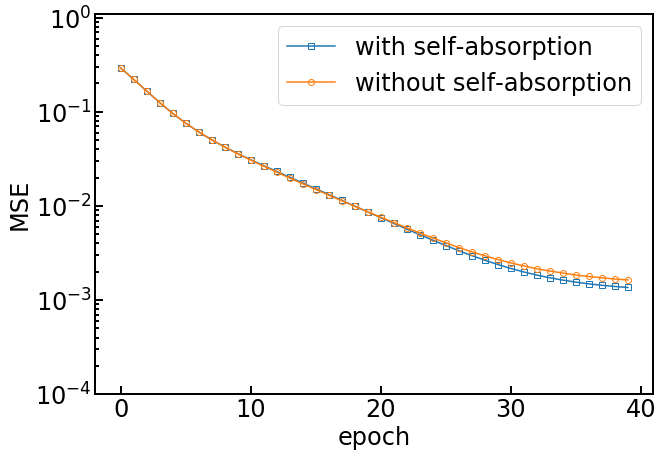

In [8]:
mse_model_selfAb = np.load(os.path.join(recon_path_selfAb, f_mse_model + '.npy'))
mse_model_woSelfAb = np.load(os.path.join(recon_path_woSelfAb, f_mse_model + '.npy'))
epoch_ls = np.arange(0,40)

fig0 = plt.figure(figsize = (10,7))
gs0 = gridspec.GridSpec(nrows=1, ncols=1)

fig0_ax0 = fig0.add_subplot(gs0[0,0])
fig0_ax0.plot(epoch_ls, mse_model_selfAb, marker='s', fillstyle='none', label="with self-absorption")
fig0_ax0.plot(epoch_ls, mse_model_woSelfAb, marker='o', fillstyle='none', label="without self-absorption")
fig0_ax0.set_yscale('log')
fig0_ax0.set_xlabel("epoch", fontsize=24)
fig0_ax0.set_ylabel("MSE", fontsize=24)
fig0_ax0.set_ylim([1.0E-4, 1.1])
fig0_ax0.tick_params(axis='both', which='major', labelsize=24, width=2, length=8)
fig0_ax0.tick_params(axis='both', which='major', direction='in', width=2, length=8)
fig0_ax0.tick_params(axis='both', which='minor', labelsize=24, width=2, length=4)
fig0_ax0.tick_params(axis='both', which='minor', direction='in', width=2, length=4)
fig0_ax0.spines["top"].set_linewidth(2)
fig0_ax0.spines["bottom"].set_linewidth(2)
fig0_ax0.spines["left"].set_linewidth(2)
fig0_ax0.spines["right"].set_linewidth(2)
fig0_ax0.legend(fontsize=24)
plt.savefig('Self_absorption_effect_convergence.pdf', format='pdf', dpi=600)